In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'../data/Original-Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Data**

In [1]:
cyaug_path = r'../data/CyAUG-Dataset'
original_path = r'../data/Orignal-Dataset'

In [ ]:
pip install git+https://github.com/keras-team/keras-preprocessing.git

# **Explanatory Data Analysis**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [4]:
from pathlib import Path
import requests
import PIL
from io import BytesIO
import random
from PIL import Image

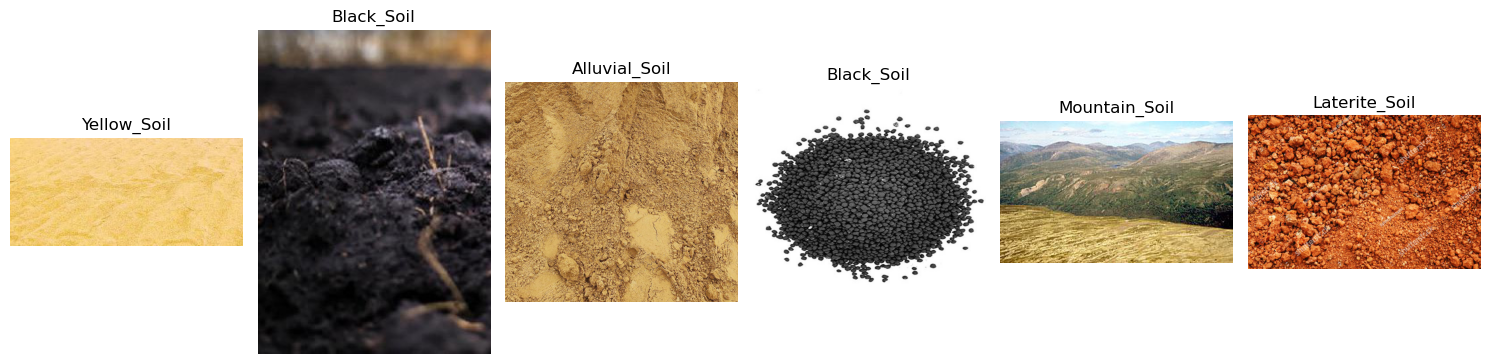

In [6]:
img_dir = Path(cyaug_path)

# Find all image files recursively
img_files = list(img_dir.rglob("*.jpg"))  # or *.png, depending on your dataset

# Sample and plot
sample_images = random.sample(img_files, 6)

fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for ax, img_path in zip(axes, sample_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_path.parent.name)  # or use img_path.name[:20]
    ax.axis("off")

plt.tight_layout()
#plt.savefig('/kaggle/working/sample_1.png')  # ✅ Saves to file, not notebook
#plt.close() 
plt.show()

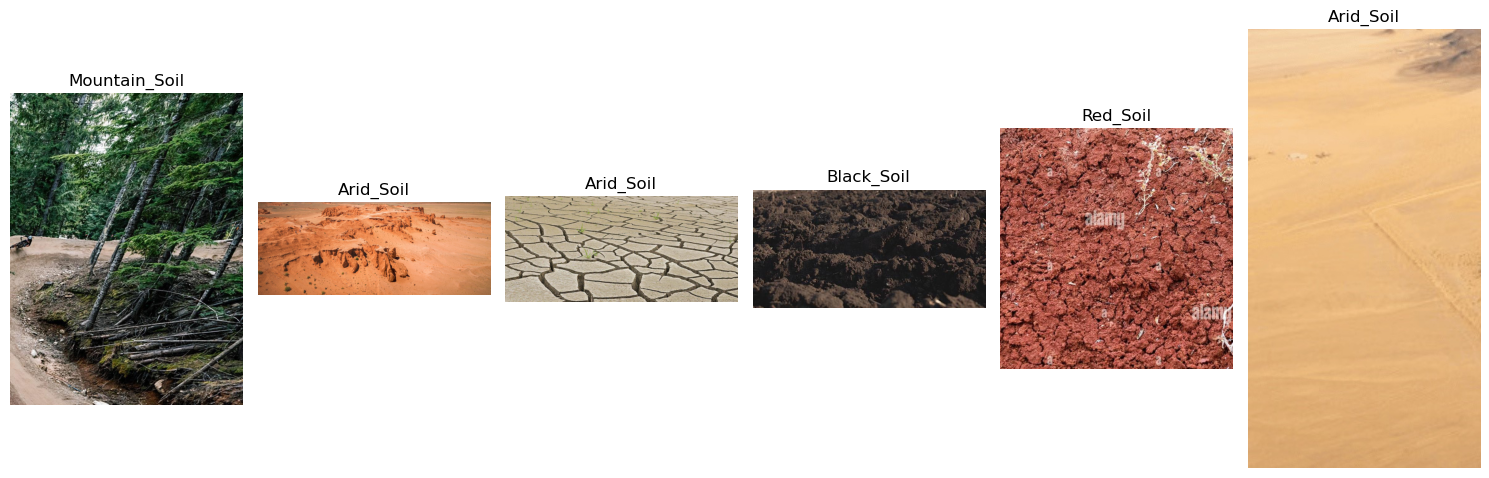

In [7]:
img_dir = Path(original_path)

# Find all image files recursively
img_files = list(img_dir.rglob("*.jpg"))  # or *.png, depending on your dataset

# Sample and plot
sample_images = random.sample(img_files, 6)

fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for ax, img_path in zip(axes, sample_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_path.parent.name)  # or use img_path.name[:20]
    ax.axis("off")

plt.tight_layout()
#plt.savefig('/kaggle/working/sample_1.png')  # ✅ Saves to file, not notebook
#plt.close() 
plt.show()

# **Prepare the data**

**Standardizing The Data** 

Our image are already in a standard size (224x224), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

In [9]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )

train_generator = gen.flow_from_directory(
    directory = original_path, # images data path / folder in which images are there
    subset="training",
    color_mode="rgb",
    target_size = (224, 224), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)


validation_generator = gen.flow_from_directory(
    #df_val, # dataframe
    directory = original_path, # images data path / folder in which images are there
    subset = "validation",
    color_mode="rgb",
    target_size = (224, 224), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)

Found 954 images belonging to 7 classes.
Found 234 images belonging to 7 classes.


In [10]:
x,y = next(train_generator)
x.shape # input shape of one record is (224, 224,3) , 64: is the batch size

(64, 224, 224, 3)

# **Plot images**

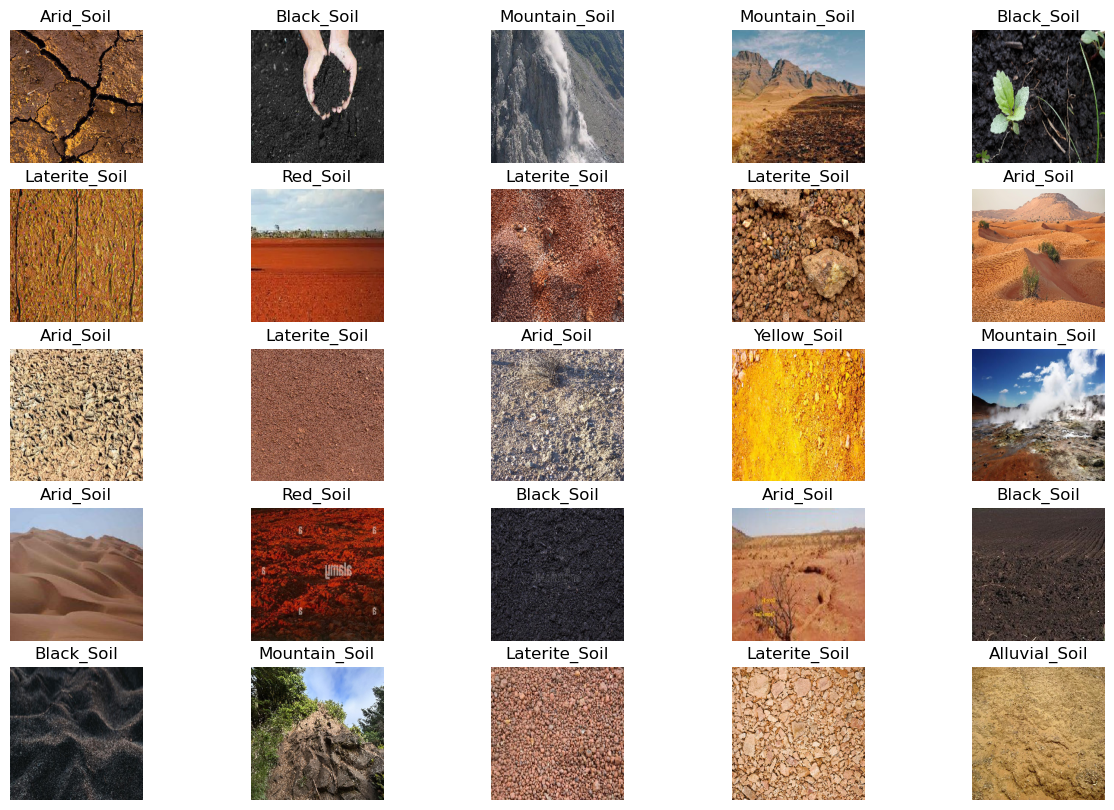

In [11]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [17]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
from sklearn.utils.class_weight import compute_class_weight
from keras import layers
import tensorflow_datasets as tfds

ImportError: cannot import name 'core' from partially initialized module 'tensorflow_datasets' (most likely due to a circular import) (c:\Users\maxde\anaconda3\envs\dldna\lib\site-packages\tensorflow_datasets\__init__.py)

# **Building the CNN Model**

We'll build a small version of the Xception network. 

Note that:

* We start the model by a Rescaling layer.
* We include a Dropout layer before the final classification layer.

In [18]:
# define the model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) 
x = Dropout(0.2)(x)  
predictions = Dense(7, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,966,831 (87.61 MB)

 Trainable params: 22,912,303 (87.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

# **Train the Model**

In [19]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for 
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [20]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

In [ ]:
batch_size=64
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5,
                    callbacks=[early])

Epoch 1/5


# **Run Inference On New Data**

In [ ]:
image_size = (224, 224)

In [ ]:
img = keras.utils.load_img("/kaggle/input/comprehensive-soil-classification-datasets/CyAUG-Dataset/Alluvial_Soil/103.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% Alluvial Soil and {100 * score:.2f}% not.")

# **Plotting The Training And Validation Accuracy And Loss**

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['lines.linestyle'] = '--'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')


In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.title(f'Training and Validation Loss. \nTrain Loss: 
         # {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

# **Confusion Matrix**

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# === Evaluate with Confusion Matrix ===
y_true = []
y_pred = []

for images, labels in validation_generator:
    logits = model.predict(images)
    preds = tf.argmax(logits, axis=1)
    y_true.extend(labels)
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(16, 16))  # You can adjust size as needed
disp.plot(ax=ax, cmap='Oranges')
#disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix on Validation Set")
plt.show()

# **Evaluate Test Dataset**

In [ ]:
# Evaluate
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")